**Tutorial # 3 - Contrast agnostic training**

Goals:

1.   Create synthetic images
2.   Determine GMM parameters

**Import libraries**

In [ ]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt # plotting purposes

import tensorflow as tf
import os
from os.path import join, basename
import os.path
from tensorflow import keras
from tensorflow.keras import layers
import cv2


**Mount drive**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


(256, 128, 256, 1)


Text(0.5, 1.0, 'Gray Matter')

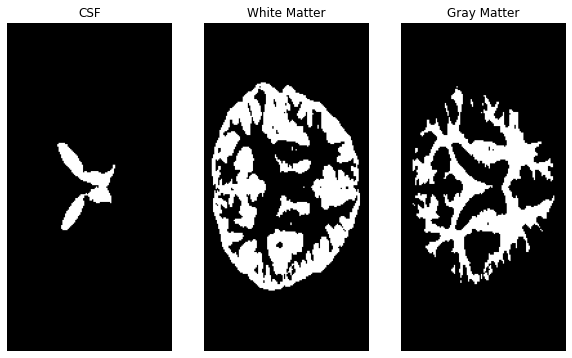

In [ ]:
predicted_mask=testing_labels.copy()
predCSF         = predicted_mask.copy()
predCSF[predCSF!=1] = 0 #CSF
predWM          = predicted_mask.copy()
predWM[predWM!=2]   = 0 #GM
predGM          = predicted_mask.copy()
predGM[predGM!=3]   = 0 #WM

a=predCSF
print(a.shape)
b=predWM/2
c=predGM/3


plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(np.squeeze(a[:,:,150]),cmap='gray')
plt.axis('off')
plt.title('CSF')

plt.subplot(1,3,2)
plt.imshow(np.squeeze(b[:,:,150]),cmap='gray')
plt.axis('off')
plt.title('White Matter')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(c[:,:,150]),cmap='gray')
plt.axis('off')
plt.title('Gray Matter')

# **START**

---



---



---



---



**Define parameters**

In [ ]:
# dataset parameters
FNAME_PATTERN = '/content/drive/MyDrive/MISAFinal/'


N_VOLUMES = 10
IMAGE_SIZE = (256,128,256)

# network parameters
N_CLASSES = 5
N_INPUT_CHANNELS = 1
PATCH_SIZE = (32, 32)
PATCH_STRIDE = (32, 32)

# training, validation, test parameters
TRAINING_VOLUMES = [16, 4, 5, 6, 7, 8, 9, 3, 1, 18] 
VALIDATION_VOLUMES = [11, 12,13,14]
TEST_VOLUMES = [17]

# data preparation parameters
CONTENT_THRESHOLD = 0.3

# training parameters
N_EPOCHS = 50
BATCH_SIZE = 32
PATIENCE = 10
MODEL_FNAME_PATTERN = 'model.h5'
OPTIMISER = 'Adam'
LOSS = 'categorical_crossentropy'

In [ ]:
filePath= 'drive/MyDrive/MISAFinal/TrainingValidationTestSets/Validation_Set/.DS_Store'
if os.path.exists(filePath):
    os.remove(filePath)

**Load raw data**

---



---



---



---



In [ ]:
!pip install simpleITK 

     |████████████████████████████████| 48.4 MB 3.5 MB/s 


In [ ]:
import SimpleITK as sitk


In [ ]:
def load_data(n_volumes, image_size,data_path):
  data_traces= os.listdir(data_path)
  T1_volumes = np.zeros((n_volumes, *image_size, 1))
  labels = np.zeros((n_volumes, *image_size, 1))
  x=0
  for i in enumerate(data_traces) :
    print(i[1])
    img_data = nib.load(data_path+'/'+f'{i[1]}'+'/'+f'{i[1]}.nii.gz')
    #img_data = nib.load(fname_pattern.format(i+1, 'T1'))
    T1_volumes[x] = img_data.get_fdata()

    seg_data = nib.load(data_path+'/'+f'{i[1]}'+'/'+f'{i[1]}_seg.nii.gz')
    labels[x] = seg_data.get_fdata()
    x=x+1

  return (T1_volumes, labels)

## **Function for 5labels **

---



---


IBSR_09
IBSR_05
IBSR_18


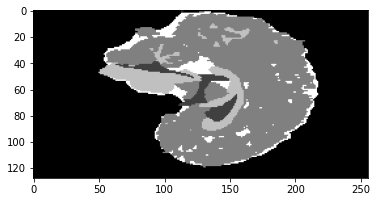

In [ ]:
data_path= '/content/drive/My Drive/MISAFinal/TrainingValidationTestSets/Validation_Set' # 256,128,256,1
data_traces= os.listdir(data_path)
#print(len(data_traces)) #10
for i in enumerate(data_traces):
  print(i[1])
  volume=nib.load(data_path+'/'+f'{i[1]}'+'/'+f'{i[1]}.nii.gz')
  labels=nib.load(data_path+'/'+f'{i[1]}'+'/'+f'{i[1]}_seg.nii.gz')
  image=volume.get_fdata()
  label=labels.get_fdata()
  image1=np.array([image!=0])[0]
  image2= label==0
  result=np.multiply((np.array([image1!=0])[0]),image2)
  newLabels = label.copy()
  newLabels[result]=4
  plt.imshow(np.squeeze(newLabels[129,:,:]),cmap='gray')
  affine = np.eye(4)
  nifti_file = nib.Nifti1Image(newLabels, affine)
  nib.save(nifti_file, data_path+'/'+f'{i[1]}'+'/'+f'{i[1]}_5labels_seg.nii.gz')



In [ ]:
(training_volumes, training_labels_0) = load_data(7,IMAGE_SIZE,'drive/MyDrive/MISAFinal/TrainingValidationTestSets/Training_Set')

IBSR_07
IBSR_01
IBSR_08
IBSR_04
IBSR_03
IBSR_16
IBSR_06


In [ ]:
(training_volumes_T1, training_labels) = load_data(7,IMAGE_SIZE,'drive/MyDrive/MISAFinal/TrainingValidationTestSets/Training_Set')

IBSR_07
IBSR_01
IBSR_08
IBSR_04
IBSR_03
IBSR_16
IBSR_06


In [ ]:
(validation_volumes_T1, validation_labels) = load_data(3,IMAGE_SIZE,'drive/MyDrive/MISAFinal/TrainingValidationTestSets/Validation_Set')

IBSR_09
IBSR_05
IBSR_18


In [ ]:
(testing_volumes_T1, testing_labels) = load_data(5,IMAGE_SIZE,'drive/MyDrive/MISAFinal/TrainingValidationTestSets/testing_Set')

IBSR_12
IBSR_11
IBSR_17
IBSR_13
IBSR_14


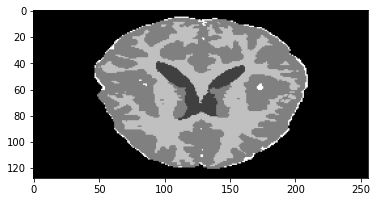

In [ ]:
plt.imshow(np.squeeze(testing_labels[2][150,:,:]),cmap='gray')


**Pre-process data**

---



---



---



---



In [ ]:
def z_score_standardisation(x, avg, std):
  return (x-avg)/std

ref_avg = training_volumes_T1[training_labels!=0].mean()
ref_std = training_volumes_T1[training_labels!=0].std()

#training_volumes_T1 = z_score_standardisation(training_volumes_T1, ref_avg, ref_std)
#validation_volumes_T1 = z_score_standardisation(validation_volumes_T1, ref_avg, ref_std)
#testing_volumes_T1 = z_score_standardisation(testing_volumes_T1, ref_avg, ref_std)

In [ ]:
!pip install SimpleITK
import SimpleITK as sitk
def Adativehistogram_equalization(ref,alpha,beta):

    histogramEqualization = sitk.AdaptiveHistogramEqualizationImageFilter()
    histogramEqualization.SetAlpha(alpha)
    histogramEqualization.SetBeta(beta)
    equalized_volume = histogramEqualization.Execute(ref)
    
    return equalized_volume

def histogram_matching(mov_scan, ref_scan,
                       histogram_levels=2048,
                       match_points=100,
                       set_th_mean=True):
    """
    Histogram matching following the method developed on
    Nyul et al 2001 (ITK implementation)
    inputs:
    - mov_scan: np.array containing the image to normalize
    - ref_scan np.array containing the reference image
    - histogram levels
    - number of matched points
    - Threshold Mean setting
    outputs:
    - histogram matched image
    """

    # convert np arrays into itk image objects
    ref = sitk.GetImageFromArray(ref_scan.astype('float32'))
    mov = sitk.GetImageFromArray(mov_scan.astype('float32'))

    # perform histogram matching
    caster = sitk.CastImageFilter()
    caster.SetOutputPixelType(ref.GetPixelID())

    matcher = sitk.HistogramMatchingImageFilter()
    matcher.SetNumberOfHistogramLevels(histogram_levels)
    matcher.SetNumberOfMatchPoints(match_points)
    matcher.SetThresholdAtMeanIntensity(set_th_mean)
    matched_vol = matcher.Execute(mov, ref)

    return matched_vol


In [ ]:
def load_data(n_volumes, image_size,data_path):
  data_traces= os.listdir(data_path)
  T1_volumes = np.zeros((n_volumes, *image_size, 1))
  labels = np.zeros((n_volumes, *image_size, 1))
  x=0
  for i in enumerate(data_traces) :
    print(i[1])
    img_data=sitk.ReadImage(data_path+'/'+f'{i[1]}'+'/'+f'{i[1]}.nii.gz', sitk.sitkFloat32)
    normalized = z_score_standardisation(sitk.GetArrayFromImage(img_data), ref_avg, ref_std)
    Histo_mached_vol=histogram_matching(normalized,ref_array)
    final_array =  np.expand_dims(np.array(sitk.GetArrayFromImage(Histo_mached_vol)),axis=-1)
    T1_volumes[x] = final_array
    affine = np.eye(4)
    nifti_file = nib.Nifti1Image(final_array, affine)
    nib.save(nifti_file, data_path+'/'+f'{i[1]}'+'/'+f'{i[1]}_5labels_preprocessed.nii.gz')


    img_data=sitk.ReadImage(data_path+'/'+f'{i[1]}'+'/'+f'{i[1]}_5labels_seg.nii.gz', sitk.sitkFloat32)
    seg_data = np.expand_dims(np.array(sitk.GetArrayFromImage(img_data)),axis=-1)
    labels[x] = seg_data
    affine = np.eye(4)
    nifti_file = nib.Nifti1Image(seg_data, affine)
    nib.save(nifti_file, data_path+'/'+f'{i[1]}'+'/'+f'{i[1]}_5labels_preprocessed_seg.nii.gz')

    x=x+1

  return (T1_volumes, labels)

In [ ]:
path='/content/drive/My Drive/MISAFinal/TrainingValidationTestSets/Training_Set/IBSR_07/IBSR_07.nii.gz'
ref_volume=sitk.ReadImage(path, sitk.sitkFloat32)
array = sitk.GetArrayFromImage(ref_volume)
img1=np.array(array)
re=Adativehistogram_equalization(ref_volume,1.0,1.0)
ref_array=np.array(sitk.GetArrayFromImage(re))

In [ ]:
(training_volumes_T1, training_labels) = load_data(7,IMAGE_SIZE,'drive/MyDrive/MISAFinal/TrainingValidationTestSets/Training_Set')
(validation_volumes_T1, validation_labels) = load_data(3,IMAGE_SIZE,'drive/MyDrive/MISAFinal/TrainingValidationTestSets/Validation_Set')

IBSR_07
IBSR_01
IBSR_08
IBSR_04
IBSR_03
IBSR_16
IBSR_06
IBSR_09
IBSR_05
IBSR_18


In [ ]:
(testing_volumes_T1, testing_labels) = load_data(5,IMAGE_SIZE,'drive/MyDrive/MISAFinal/TrainingValidationTestSets/testing_Set')


IBSR_12
IBSR_11
IBSR_17
IBSR_13
IBSR_14
